In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import requests



# CSV
url_csv = "https://raw.githubusercontent.com/SapirGabay/ML_Project_Part1/main/sentiment.csv"
df = pd.read_csv(url_csv)

# Positive words
url_pos = "https://raw.githubusercontent.com/SapirGabay/ML_Project_Part1/main/positive-words.txt"
positive_words = set([
    line.strip() for line in requests.get(url_pos).text.splitlines()
    if line.strip() and not line.startswith(';')
])

# Negative words
url_neg = "https://raw.githubusercontent.com/SapirGabay/ML_Project_Part1/main/negative-words.txt"
negative_words = set([
    line.strip() for line in requests.get(url_neg).text.splitlines()
    if line.strip() and not line.startswith(';')
])

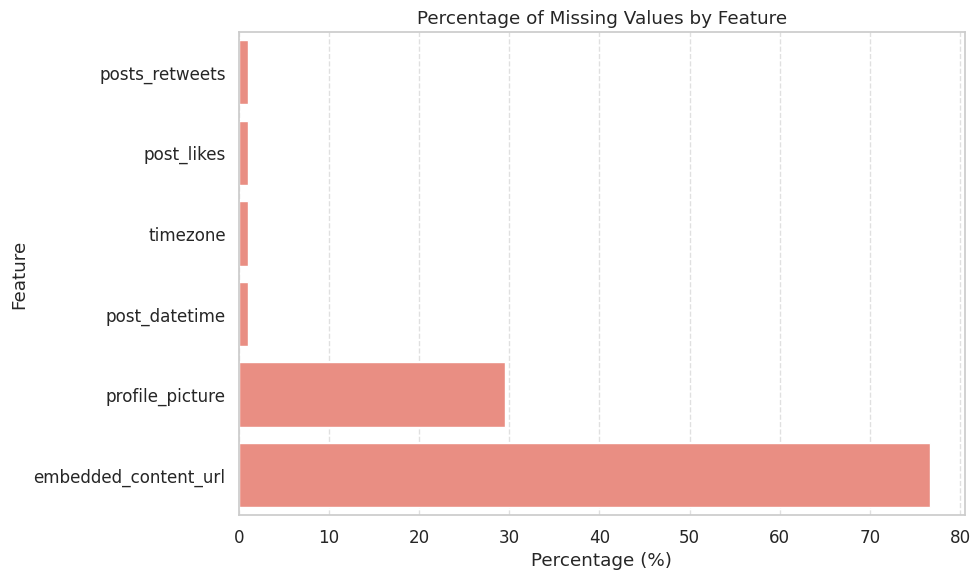

sentiment
negative    56.458763
positive    43.541237
Name: proportion, dtype: float64


In [74]:
# Pre-processing Stage
# Missing Values Handling

df_missing = df.replace('?', pd.NA)
df_clean = df_missing.dropna(subset=['sentiment']).copy()
df_clean = df_clean[df_clean.isnull().sum(axis=1) <= 3].copy()
df_clean.to_csv('sentiment_cleaned.csv', index=False)

missing_percentage = df_clean.isnull().mean() * 100
missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percentage.values, y=missing_percentage.index, color='salmon')
plt.title('Percentage of Missing Values by Feature')
plt.xlabel('Percentage (%)')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


numeric_cols = df_clean.select_dtypes(include='number').columns
for col in numeric_cols:
    if df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(median_val)

categorical_cols = ['type', 'checkmark', 'timezone']

for col in categorical_cols:
    if df_clean[col].isnull().sum() > 0:
        mode_val = df_clean[col].mode()[0]
        df_clean[col] = df_clean[col].fillna(mode_val)


print(df_clean['sentiment'].value_counts(normalize=True) * 100)


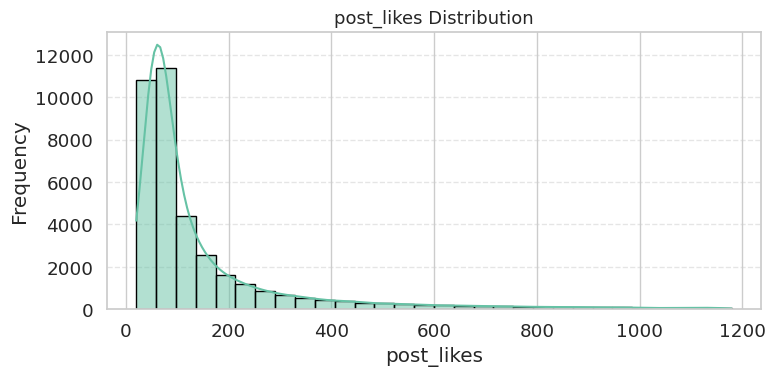

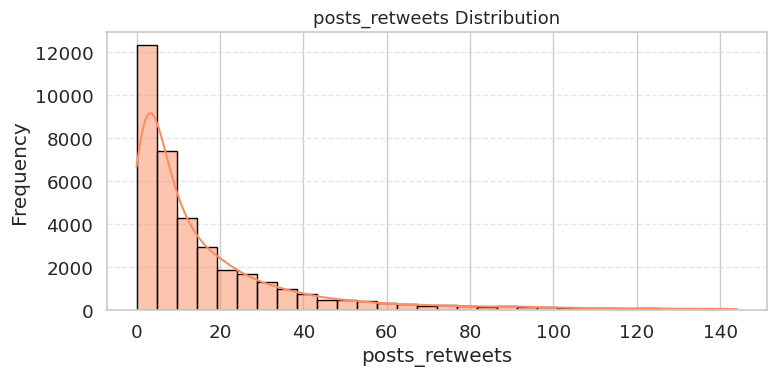

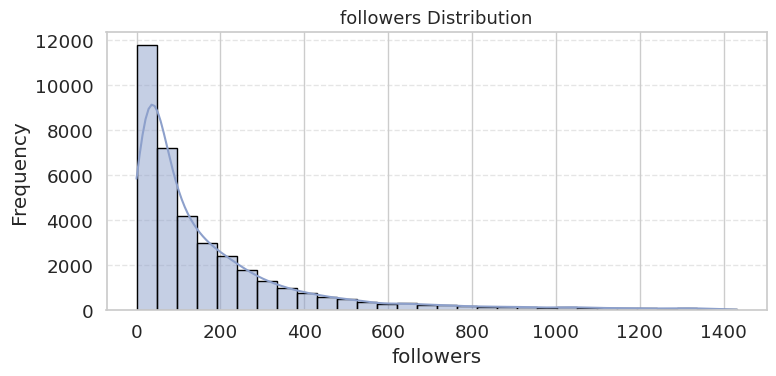

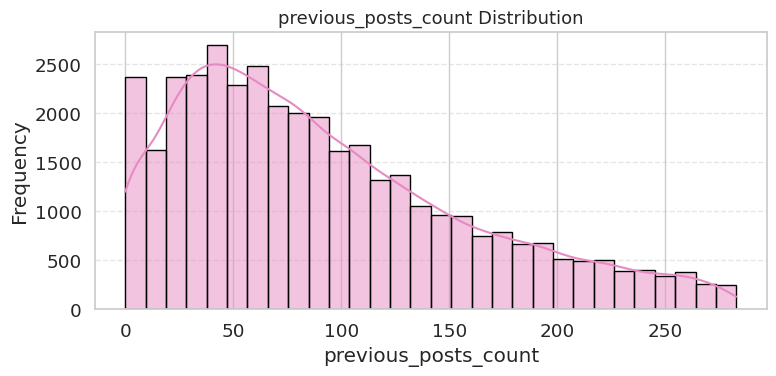

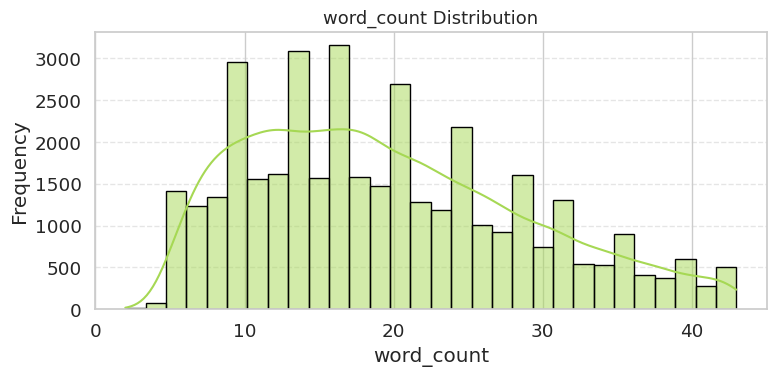

In [75]:
sns.set(style="whitegrid", font_scale=1.2)
numeric_cols = ['post_likes', 'posts_retweets', 'followers', 'previous_posts_count']
df[numeric_cols] = df[numeric_cols].replace('?', np.nan)
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

def plot_hist_trimmed(col, color):
    upper = df[col].quantile(0.95)  # חיתוך ב-95%
    plt.figure(figsize=(8, 4))
    sns.histplot(df[df[col] <= upper][col], bins=30, kde=True, color=color, edgecolor='black')
    plt.title(f'{col} Distribution', fontsize=13)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_hist_trimmed('post_likes', '#66c2a5')
plot_hist_trimmed('posts_retweets', '#fc8d62')
plot_hist_trimmed('followers', '#8da0cb')
plot_hist_trimmed('previous_posts_count', '#e78ac3')
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
plot_hist_trimmed('word_count', '#a6d854')


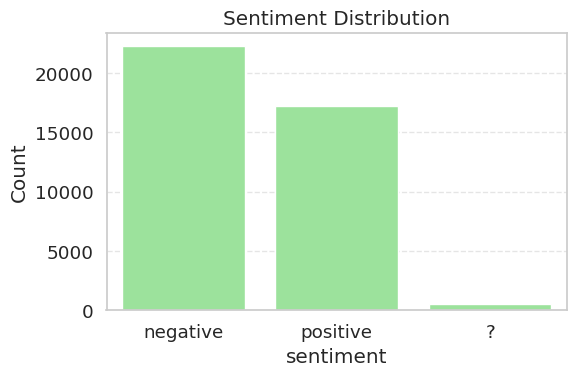

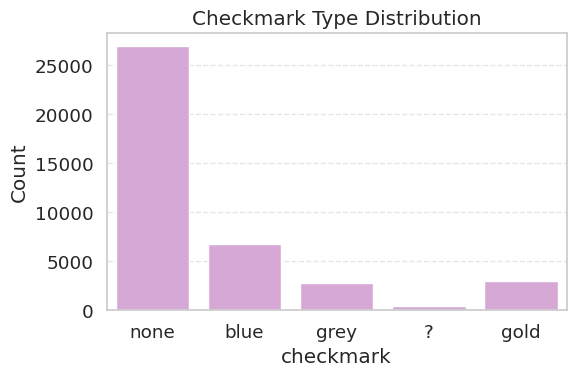

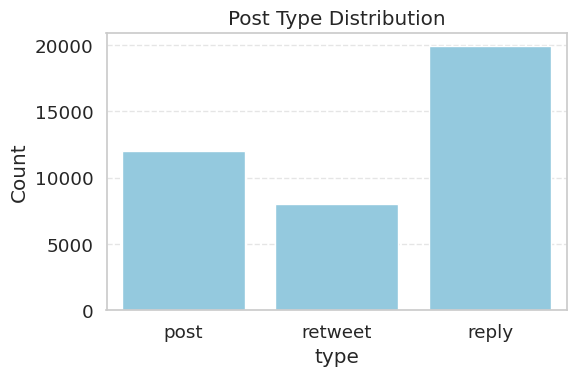

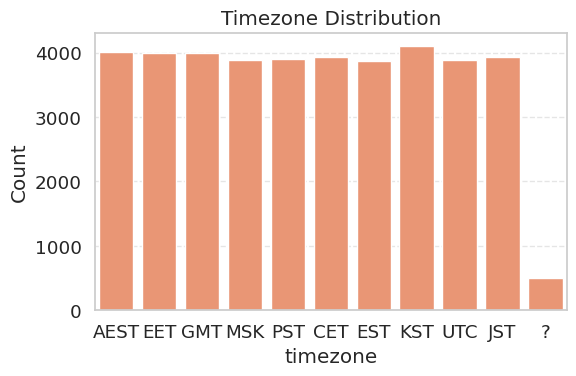

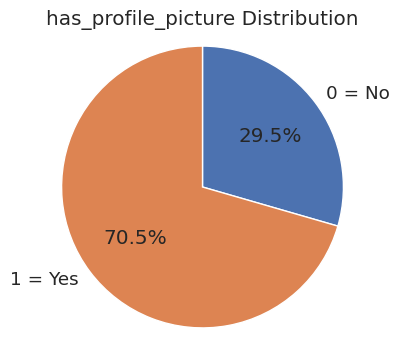

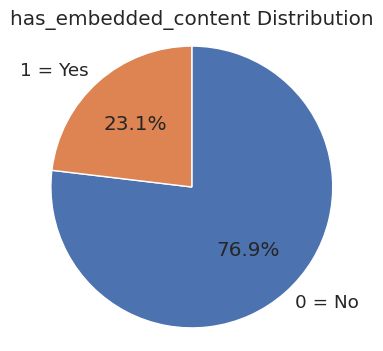

In [76]:
def plot_count(col, title, color):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df, color=color)
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
plot_count('sentiment', 'Sentiment Distribution', '#90EE90')
plot_count('checkmark', 'Checkmark Type Distribution', '#DDA0DD')
plot_count('type', 'Post Type Distribution', '#87CEEB')
plot_count('timezone', 'Timezone Distribution', '#fc8d62')

df['has_profile_picture'] = df['profile_picture'].notna().astype(int)

df['has_embedded_content'] = df['embedded_content_url'].notna().astype(int)

binary_vars = ['has_profile_picture', 'has_embedded_content']

for var in binary_vars:
    counts = df[var].value_counts().sort_index()
    labels = ['0 = No', '1 = Yes']

    plt.figure(figsize=(4, 4))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, counterclock=False)
    plt.title(f'{var} Distribution')
    plt.axis('equal')
    plt.show()

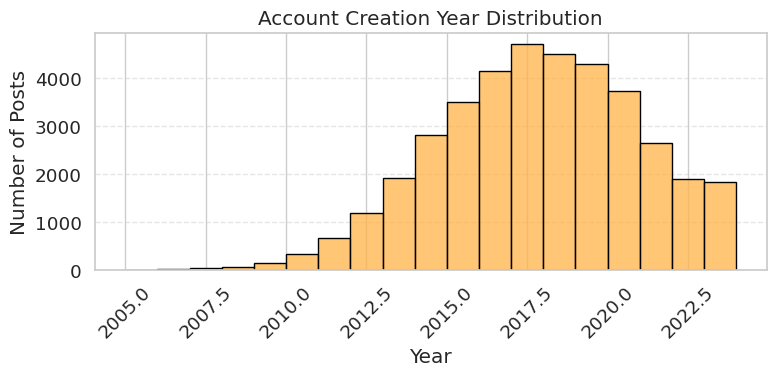

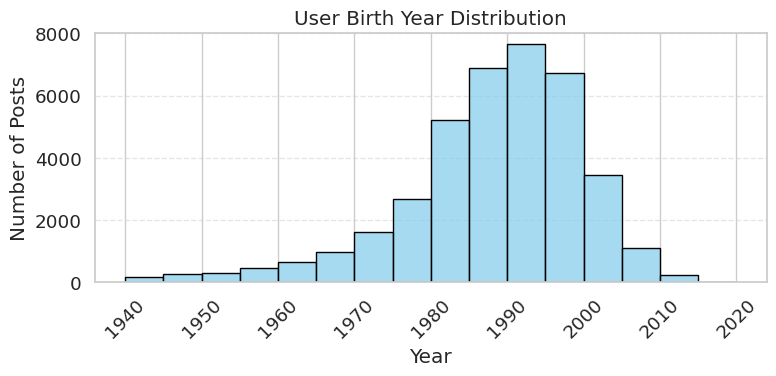

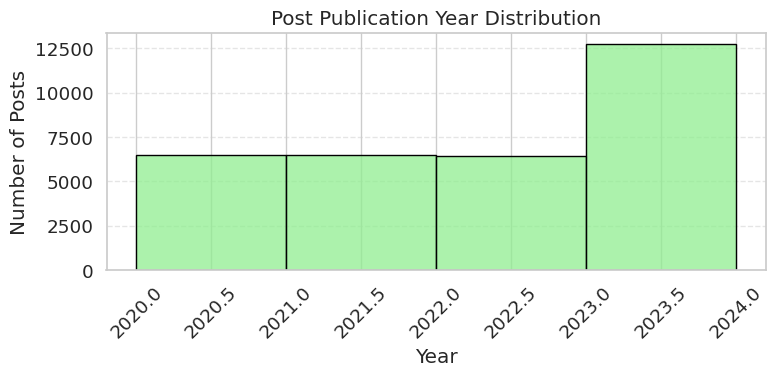

In [77]:
def plot_year_distribution(df, date_column, title, color, bins_range):
    year_col = f"{date_column}_year"
    df[year_col] = pd.to_datetime(df[date_column], errors='coerce').dt.year
    plt.figure(figsize=(8, 4))
    sns.histplot(df[year_col].dropna(), bins=bins_range, color=color, edgecolor='black')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Number of Posts')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_year_distribution(df_clean, 'account_creation_date', 'Account Creation Year Distribution', '#FFB347', range(2005, 2025))
plot_year_distribution(df_clean, 'birthday', 'User Birth Year Distribution', '#87CEEB', range(1940, 2025, 5))
plot_year_distribution(df_clean, 'post_datetime', 'Post Publication Year Distribution', '#90EE90', range(2020, 2025))


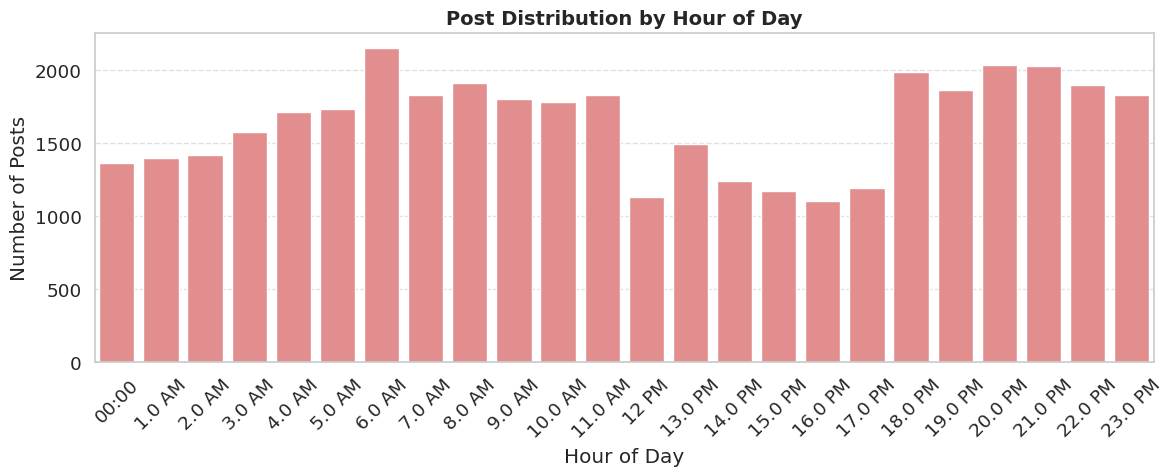

In [78]:
# Convert datetime and extract hour
df['post_datetime'] = pd.to_datetime(df['post_datetime'], errors='coerce')
df['post_hour'] = df['post_datetime'].dt.hour

# Count posts for each hour (0 to 23)
hourly_counts = df['post_hour'].value_counts().sort_index()

# Format hours to readable AM/PM format
def format_hour(hour):
    if hour == 0:
        return '00:00'
    elif hour < 12:
        return f'{hour} AM'
    elif hour == 12:
        return '12 PM'
    else:
        return f'{hour} PM'

# Create formatted x-axis labels
hour_labels = [format_hour(h) for h in hourly_counts.index]

# Plot
plt.figure(figsize=(12, 5))
sns.barplot(x=hour_labels, y=hourly_counts.values, color='lightcoral')
plt.title('Post Distribution by Hour of Day', fontsize=14, weight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

<ipython-input-79-8bee33b313e5>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=day_percentages.index, y=day_percentages.values, palette='pastel')


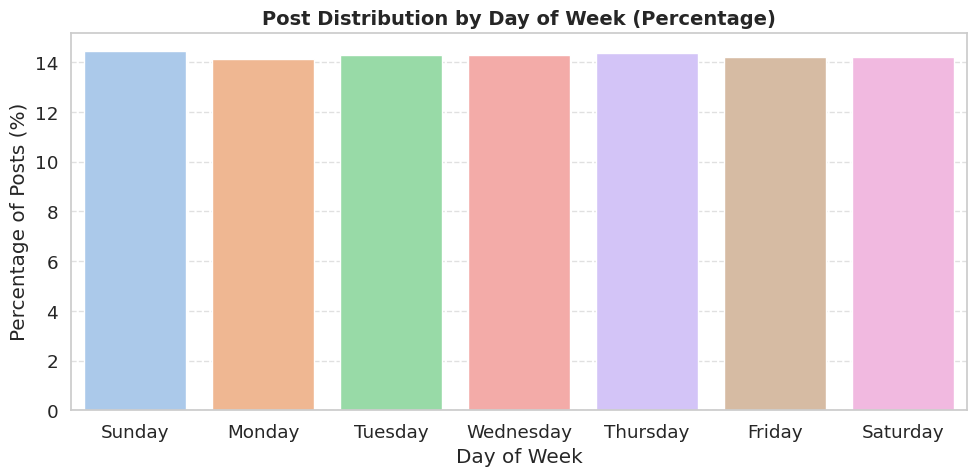

In [79]:

# Ensure datetime is parsed and extract day name
df['post_datetime'] = pd.to_datetime(df['post_datetime'], errors='coerce')
df['post_day'] = df['post_datetime'].dt.day_name()

# Define the order of days
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Calculate post counts and convert to percentages
day_counts = df['post_day'].value_counts().reindex(day_order)
day_percentages = (day_counts / day_counts.sum()) * 100

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=day_percentages.index, y=day_percentages.values, palette='pastel')
plt.title('Post Distribution by Day of Week (Percentage)', fontsize=14, weight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Percentage of Posts (%)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


<ipython-input-80-7cf50707ea53>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='word_count', data=df, palette='Set3')


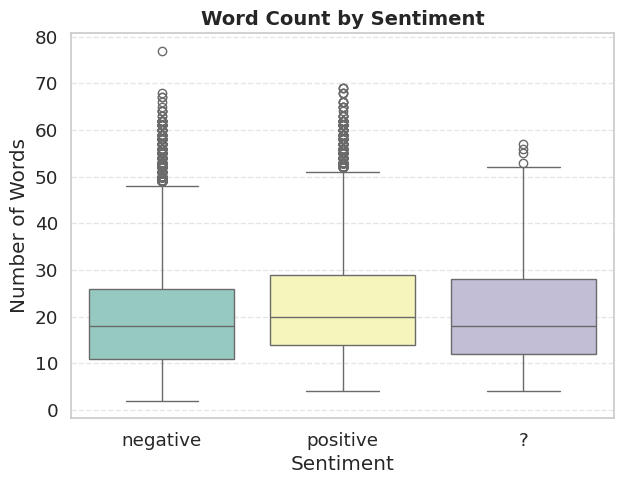

In [80]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='sentiment', y='word_count', data=df, palette='Set3')
plt.title('Word Count by Sentiment', fontsize=14, weight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Number of Words')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


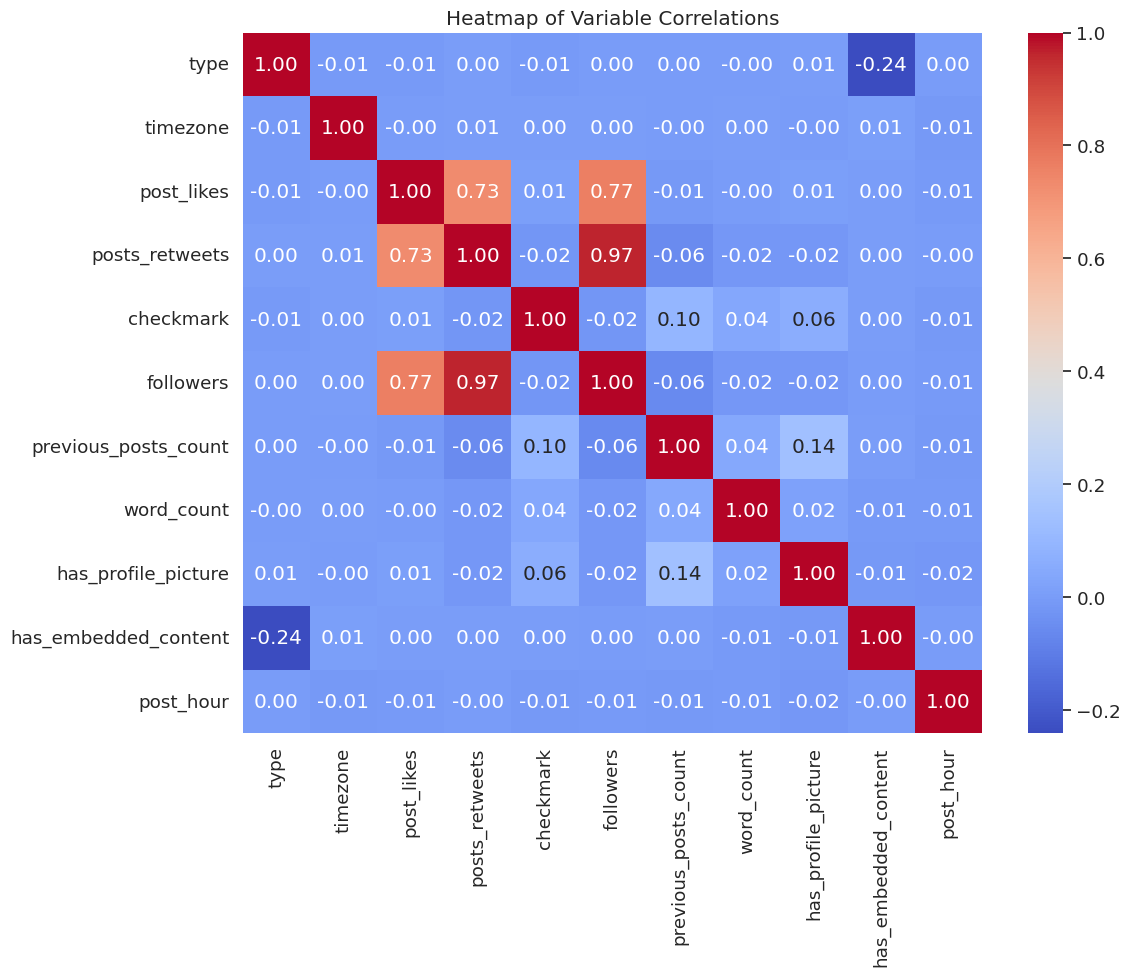

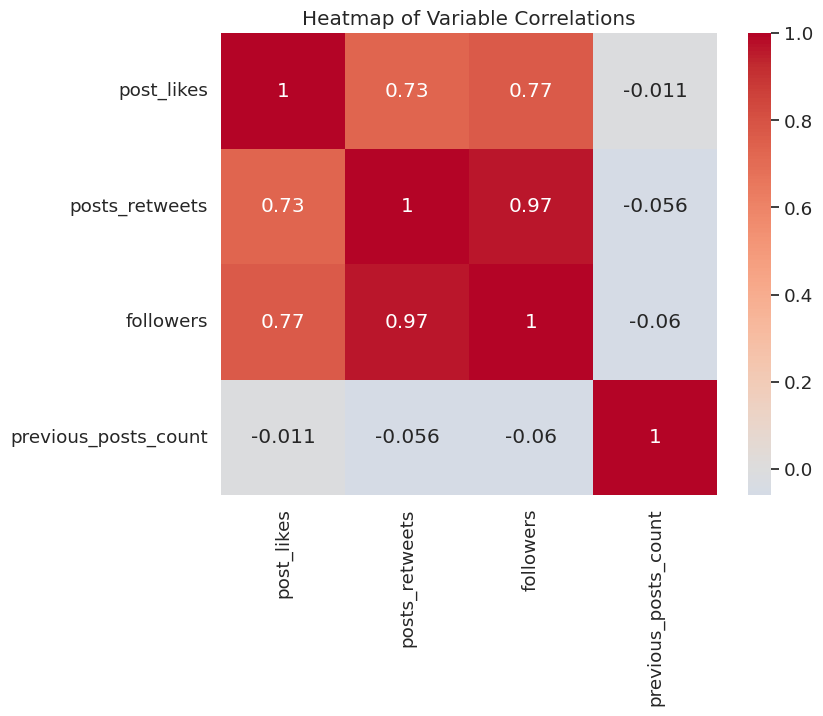

In [81]:
# Generate and visualize correlation heatmaps for selected numeric features

categorical_to_convert = ['timezone', 'checkmark', 'type']
for col in categorical_to_convert:
    df[col] = pd.factorize(df[col])[0]

numeric_data = df.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Heatmap of Variable Correlations")
plt.tight_layout()
plt.show()

cols_to_convert = ['post_likes', 'posts_retweets', 'followers', 'previous_posts_count']
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

numeric_df = df[cols_to_convert]
corr = numeric_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of Variable Correlations')
plt.show()

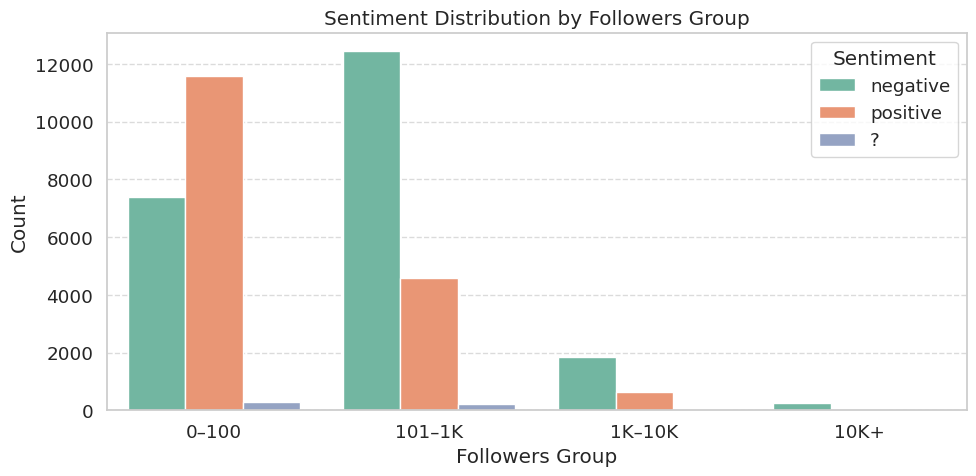

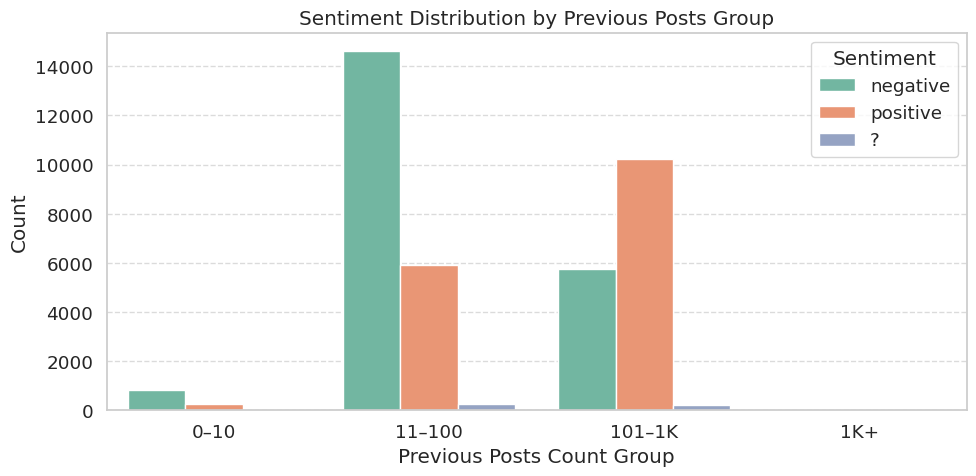

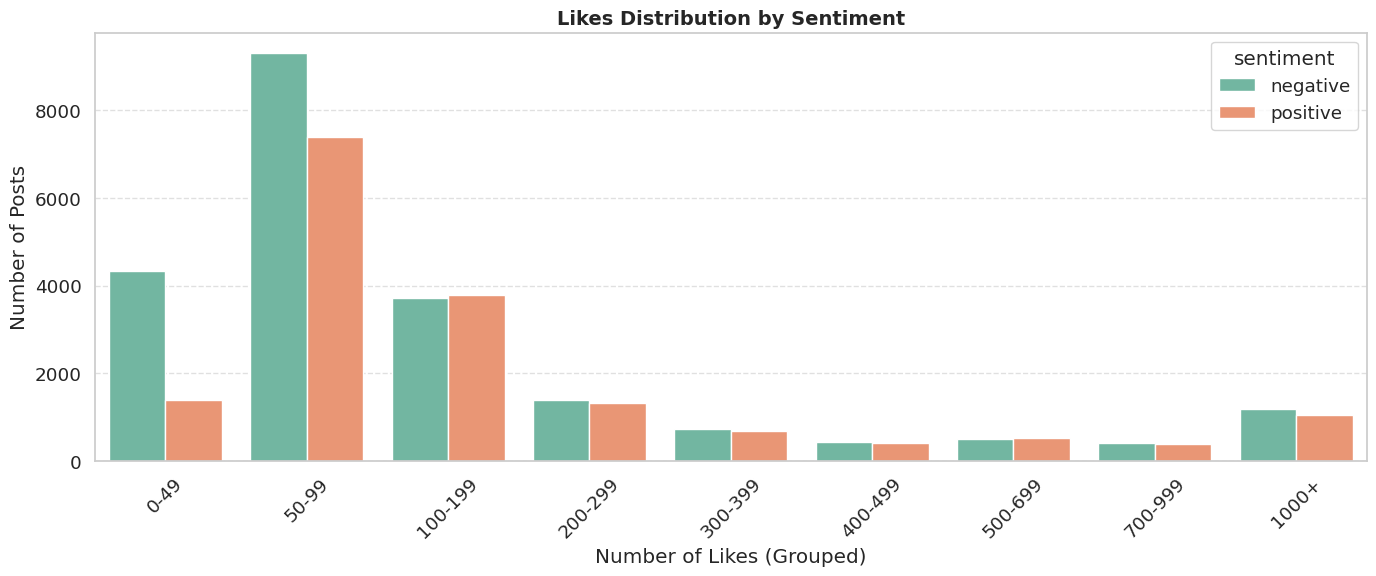

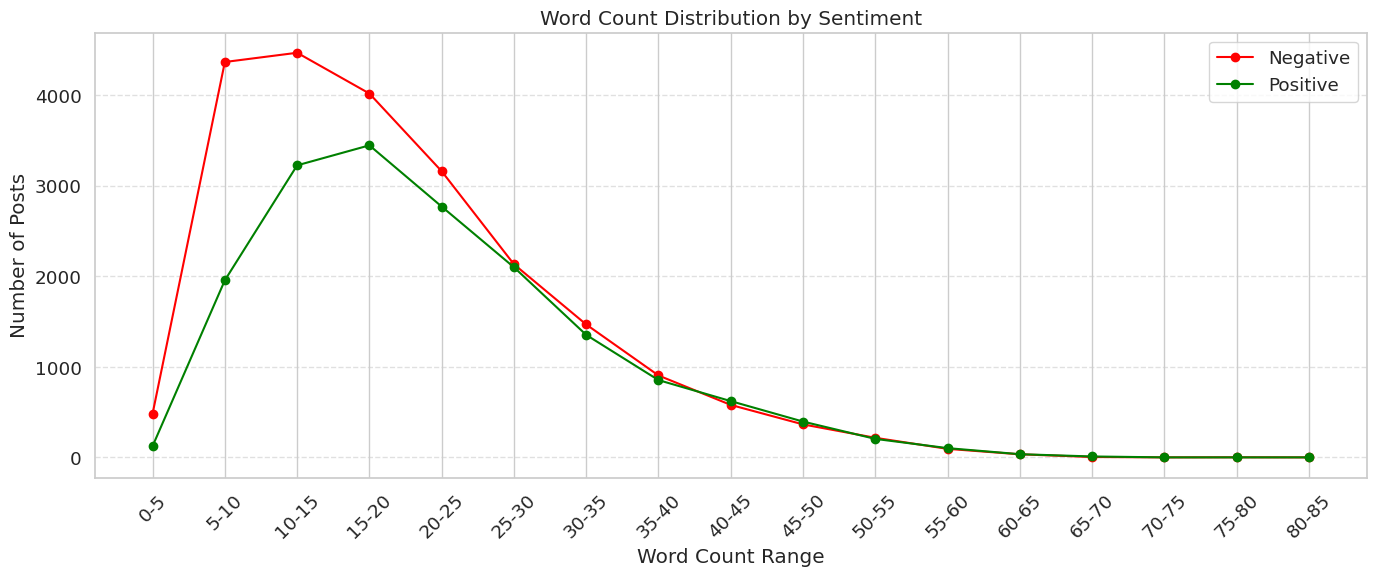

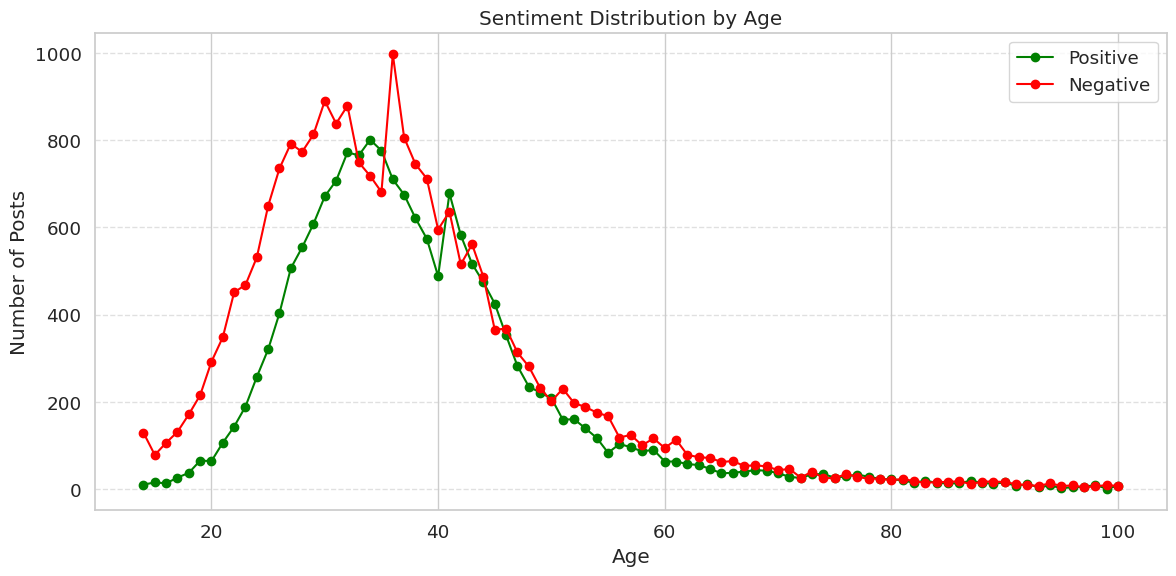

In [82]:

def prepare_bins_and_plot(df, column, bins, labels, hue='sentiment', title='', xlabel='', ylabel='Number of Posts', palette='Set2', rotate_xticks=True):
    df = df.copy()
    df[column] = pd.to_numeric(df[column], errors='coerce')
    df = df[df[hue].isin(['positive', 'negative'])]
    df = df.dropna(subset=[column])
    df[f'{column}_binned'] = pd.cut(df[column], bins=bins, labels=labels, include_lowest=True)

    plt.figure(figsize=(14, 6))
    sns.countplot(data=df, x=f'{column}_binned', hue=hue, palette=palette)
    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if rotate_xticks:
        plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_grouped_sentiment(df, group_column, title, xlabel):
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=group_column, hue='sentiment', palette='Set2')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.legend(title='Sentiment')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_sentiment_by_word_count(df):
    df = df.copy()
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    bins = list(range(0, 90, 5))
    labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
    df['word_count_bin'] = pd.cut(df['word_count'], bins=bins, labels=labels, include_lowest=True)
    word_count_dist = df.groupby(['word_count_bin', 'sentiment'], observed=False).size().unstack().fillna(0)


    plt.figure(figsize=(14, 6))
    plt.plot(word_count_dist.index, word_count_dist['negative'], color='red', label='Negative', marker='o')
    plt.plot(word_count_dist.index, word_count_dist['positive'], color='green', label='Positive', marker='o')
    plt.title('Word Count Distribution by Sentiment')
    plt.xlabel('Word Count Range')
    plt.ylabel('Number of Posts')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_sentiment_by_age(df):
    df = df.copy()
    df['birthday'] = pd.to_datetime(df['birthday'], errors='coerce')
    df['age'] = pd.to_datetime('today').year - df['birthday'].dt.year
    df = df[df['age'].between(10, 100)]
    df = df[df['sentiment'].isin(['positive', 'negative'])]
    age_sentiment_counts = df.groupby(['age', 'sentiment']).size().unstack(fill_value=0)

    plt.figure(figsize=(12, 6))
    plt.plot(age_sentiment_counts.index, age_sentiment_counts['positive'], color='green', marker='o', label='Positive')
    plt.plot(age_sentiment_counts.index, age_sentiment_counts['negative'], color='red', marker='o', label='Negative')
    plt.title('Sentiment Distribution by Age')
    plt.xlabel('Age')
    plt.ylabel('Number of Posts')
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Group followers and previous_posts_count into categories
df['followers_group'] = pd.cut(df['followers'], bins=[0, 100, 1000, 10000, float('inf')], labels=['0–100', '101–1K', '1K–10K', '10K+'])
df['posts_group'] = pd.cut(df['previous_posts_count'], bins=[0, 10, 100, 1000, float('inf')], labels=['0–10', '11–100', '101–1K', '1K+'])

plot_grouped_sentiment(df, 'followers_group', 'Sentiment Distribution by Followers Group', 'Followers Group')
plot_grouped_sentiment(df, 'posts_group', 'Sentiment Distribution by Previous Posts Group', 'Previous Posts Count Group')

prepare_bins_and_plot(
    df=df,
    column='post_likes',
    bins=[0, 50, 100, 200, 300, 400, 500, 700, 1000, float('inf')],
    labels=['0-49', '50-99', '100-199', '200-299', '300-399', '400-499', '500-699', '700-999', '1000+'],
    title='Likes Distribution by Sentiment',
    xlabel='Number of Likes (Grouped)'
)

plot_sentiment_by_word_count(df)
plot_sentiment_by_age(df)

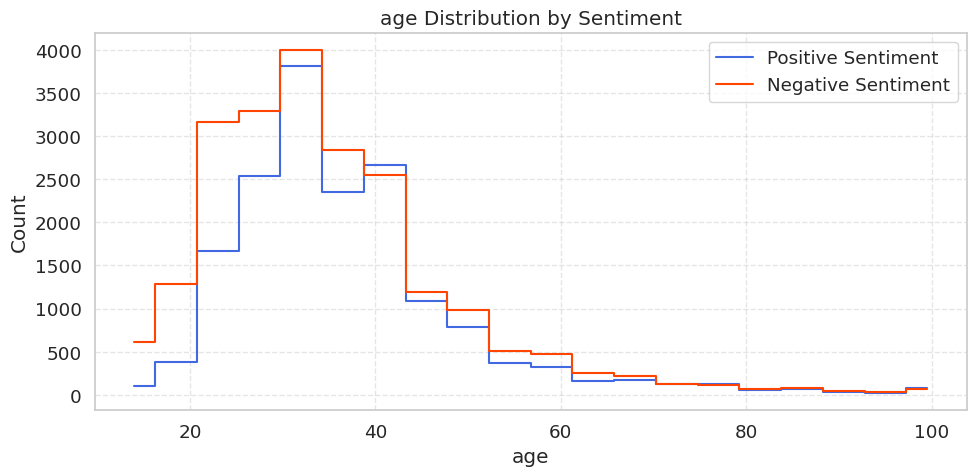

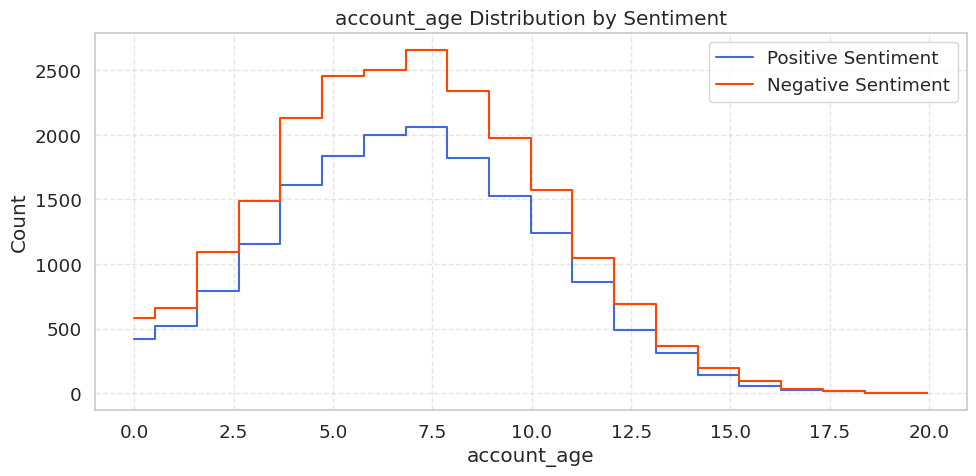

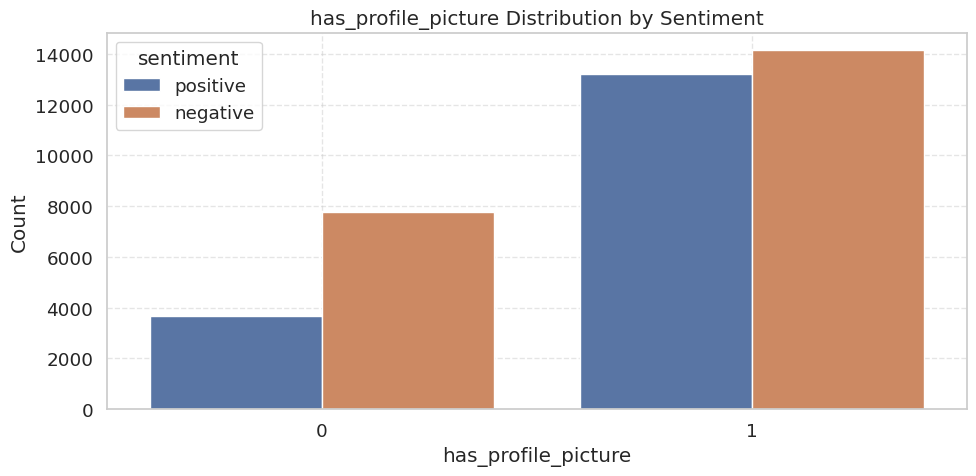

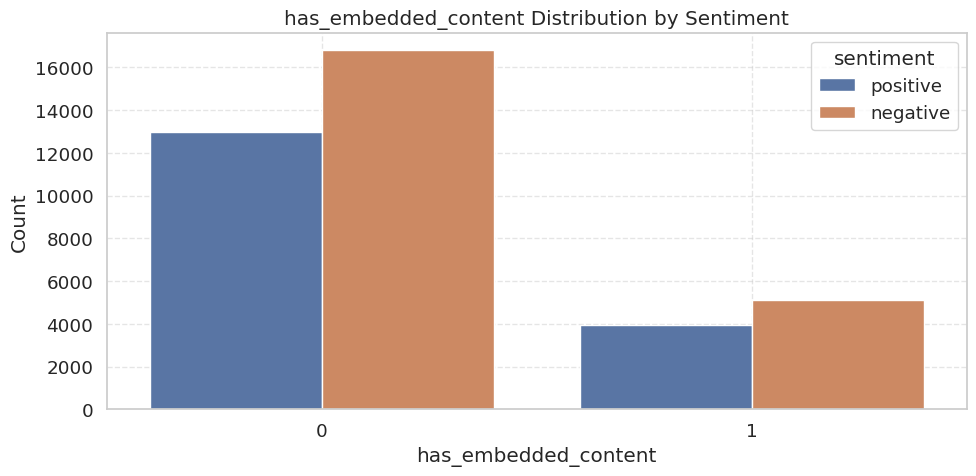

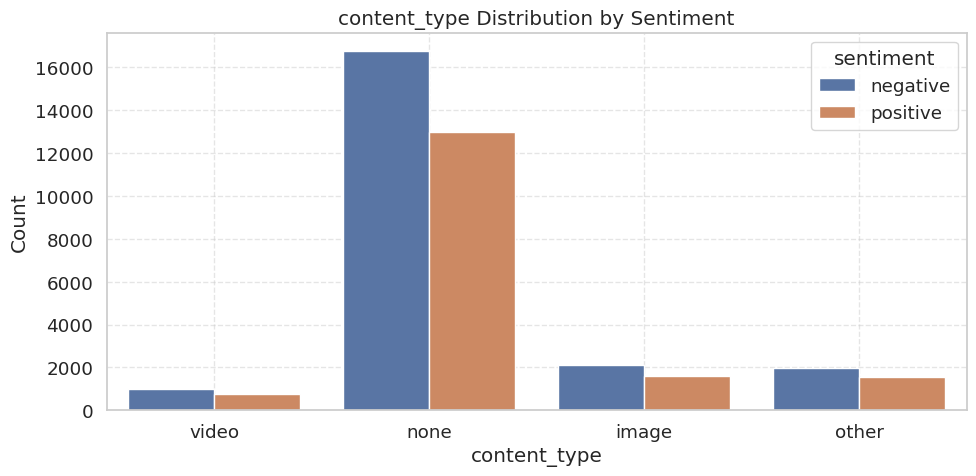

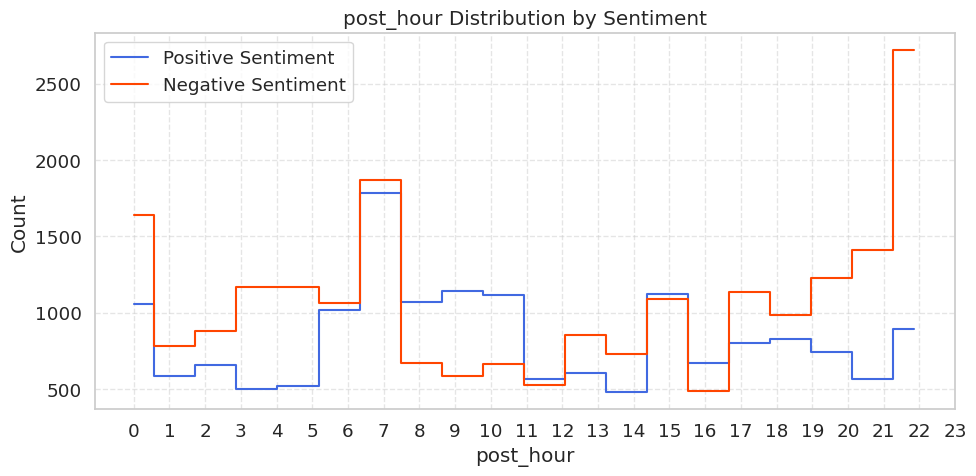

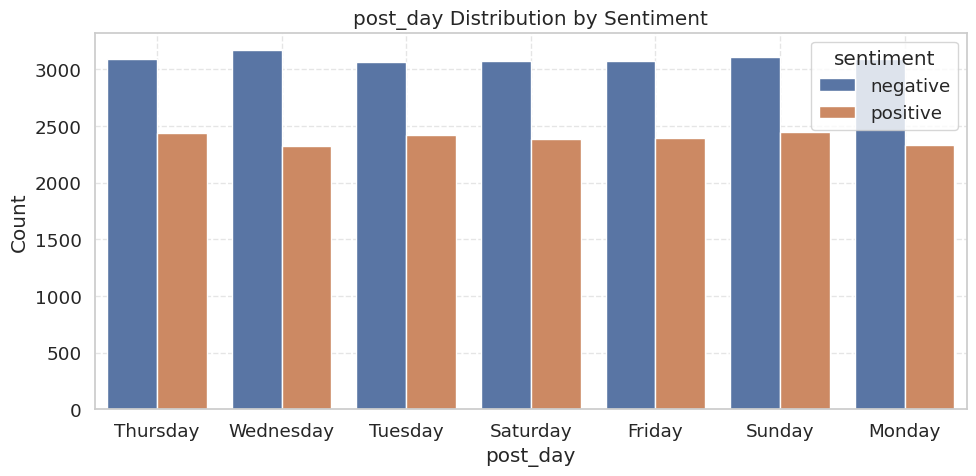

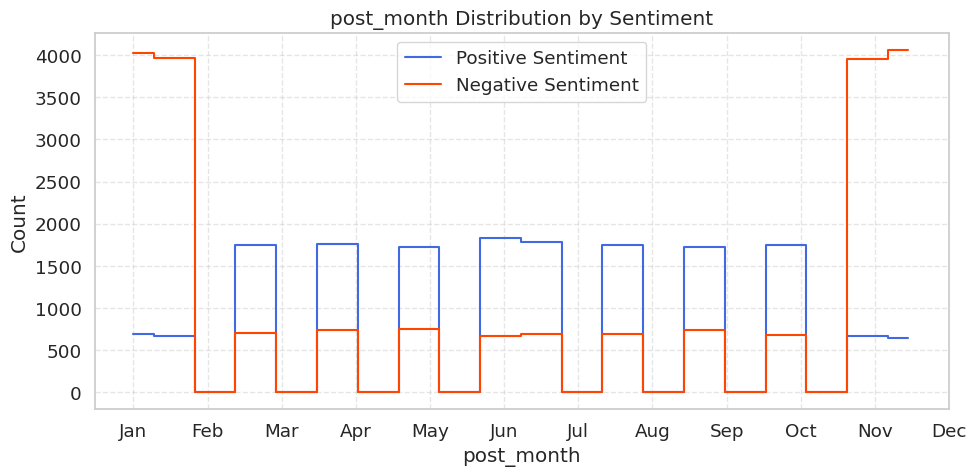

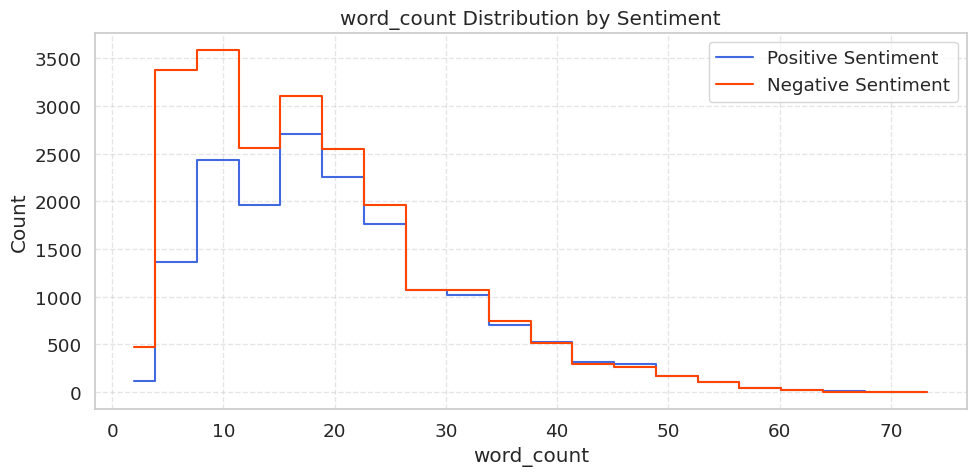

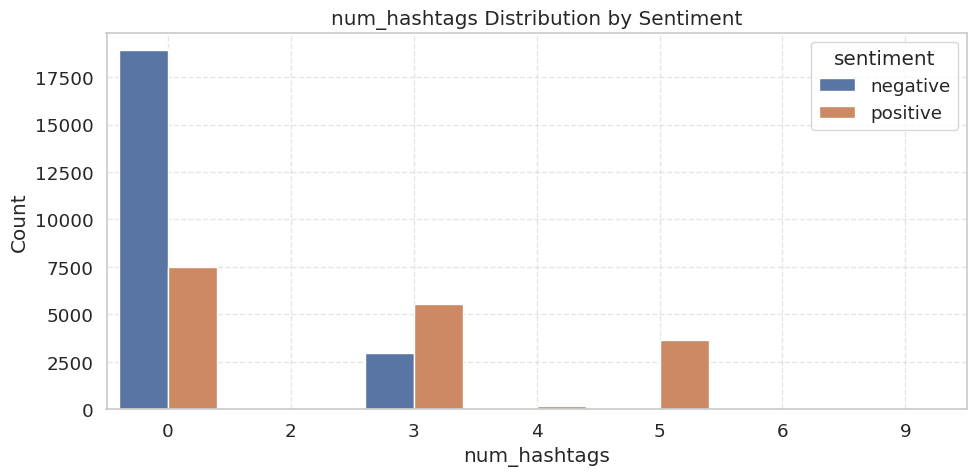

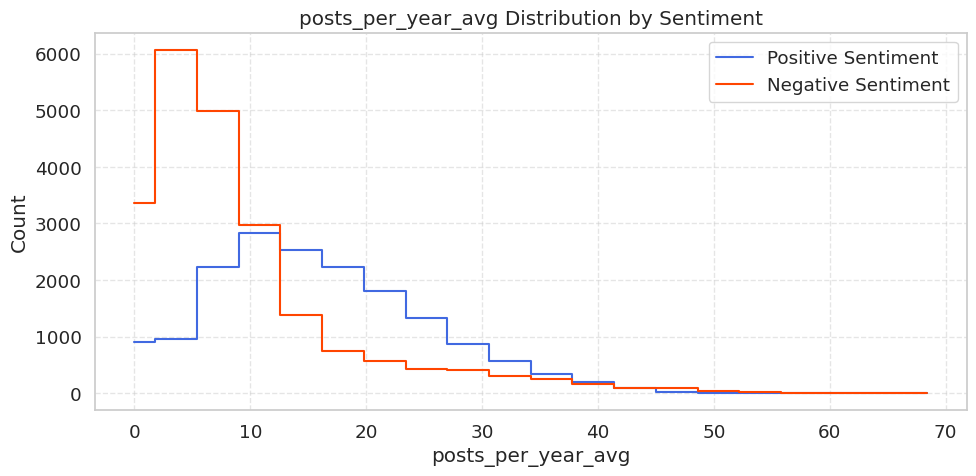

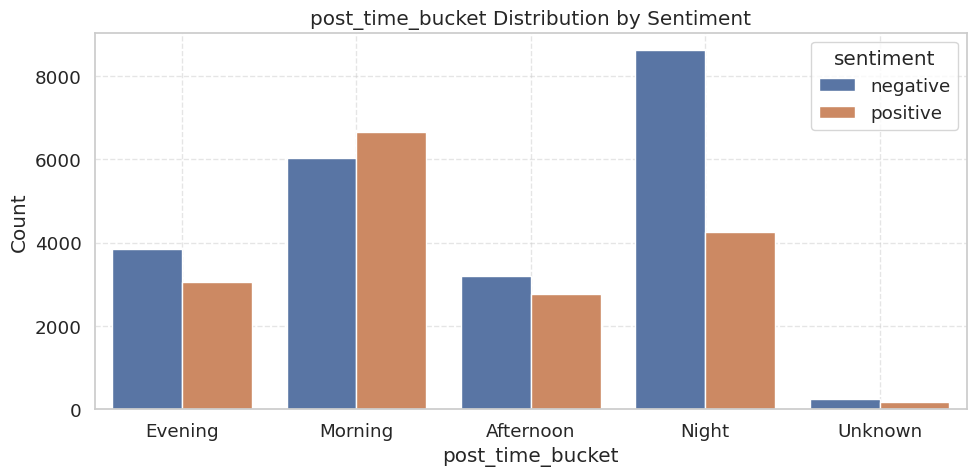

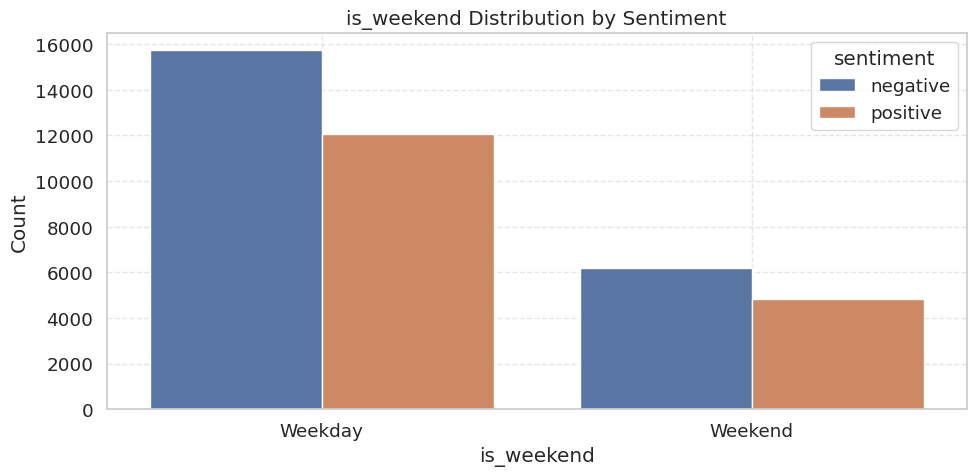

In [83]:

# Clean datetime fields and calculate age-related features
df_clean['birthday'] = pd.to_datetime(df_clean['birthday'], errors='coerce')
df_clean['account_creation_date'] = pd.to_datetime(df_clean['account_creation_date'], errors='coerce')
df_clean['post_datetime'] = pd.to_datetime(df_clean['post_datetime'], errors='coerce')

df_clean['age'] = pd.to_datetime('today').year - df_clean['birthday'].dt.year
df_clean['account_age'] = pd.to_datetime('today').year - df_clean['account_creation_date'].dt.year

# Convert to numeric
cols_to_numeric = ['post_likes', 'followers', 'previous_posts_count', 'account_age', 'posts_retweets']
for col in cols_to_numeric:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Binary features
df_clean['has_profile_picture'] = df_clean['profile_picture'].notna().astype(int)
df_clean['has_embedded_content'] = df_clean['embedded_content_url'].notna().astype(int)

# Content type classification
def detect_content_type(url):
    if pd.isna(url):
        return 'none'
    url = str(url).lower()
    if any(ext in url for ext in ['.jpg', '.jpeg', '.png', '.gif']):
        return 'image'
    elif any(ext in url for ext in ['.mp4', '.mov', '.avi']):
        return 'video'
    return 'other'

df_clean['content_type'] = df_clean['embedded_content_url'].apply(detect_content_type)

# Date/time derived features
df_clean['post_hour'] = df_clean['post_datetime'].dt.hour
df_clean['post_day'] = df_clean['post_datetime'].dt.day_name()
df_clean['post_month'] = df_clean['post_datetime'].dt.month
df_clean['is_weekend'] = df_clean['post_datetime'].dt.weekday >= 5
df_clean['is_weekend'] = df_clean['is_weekend'].map({True: 'Weekend', False: 'Weekday'})

def bucket_time(hour):
    if pd.isna(hour):
        return 'Unknown'
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    return 'Night'

df_clean['post_time_bucket'] = df_clean['post_hour'].apply(bucket_time)

# Text and engagement features
df_clean['word_count'] = df_clean['text'].apply(lambda x: len(str(x).split()))
df_clean['num_hashtags'] = df_clean['text'].apply(lambda x: str(x).count('#'))
df_clean['engagement_score'] = df_clean['post_likes'] + df_clean['posts_retweets']

df_clean['likes_per_follower'] = np.where(
    df_clean['followers'] > 0,
    df_clean['post_likes'] / df_clean['followers'],
    np.nan
)

df_clean['posts_per_year_avg'] = np.where(
    (df_clean['account_age'].isna()) | (df_clean['account_age'] == 0),
    df_clean['previous_posts_count'],
    df_clean['previous_posts_count'] / df_clean['account_age']
)
features = [
    'age', 'account_age', 'has_profile_picture', 'has_embedded_content',
    'content_type', 'post_hour', 'post_day', 'post_month', 'word_count',
    'num_hashtags', 'posts_per_year_avg', 'post_time_bucket', 'is_weekend'
]

for col in features:
    if col not in df_clean.columns:
        continue

    plt.figure(figsize=(10, 5))

    if df_clean[col].dtype == 'object' or df_clean[col].nunique() < 10:
        data = df_clean[[col, 'sentiment']].dropna()
        sns.countplot(data=data, x=col, hue='sentiment')
    else:
        pos = df_clean[df_clean['sentiment'] == 'positive'][col].dropna()
        neg = df_clean[df_clean['sentiment'] == 'negative'][col].dropna()
        bins = np.histogram_bin_edges(pd.concat([pos, neg]), bins=20)
        pos_counts, _ = np.histogram(pos, bins=bins)
        neg_counts, _ = np.histogram(neg, bins=bins)
        plt.step(bins[:-1], pos_counts, where='mid', label='Positive Sentiment', color='royalblue')
        plt.step(bins[:-1], neg_counts, where='mid', label='Negative Sentiment', color='orangered')
        plt.legend()

    plt.title(f'{col} Distribution by Sentiment')
    plt.xlabel(col)
    if col == 'post_hour':
        plt.xticks(ticks=range(0, 24))
    if col == 'post_month':
        plt.xticks(ticks=range(1, 13), labels=calendar.month_abbr[1:13])
    plt.ylabel('Count')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [84]:
# likes_per_follower – if followers == 0 or NaN → 0
df_clean['followers'] = pd.to_numeric(df_clean['followers'], errors='coerce')
df_clean['post_likes'] = pd.to_numeric(df_clean['post_likes'], errors='coerce')
df_clean['likes_per_follower'] = np.where(
    df_clean['followers'] > 0,
    df_clean['post_likes'] / df_clean['followers'],
    np.nan
)

# posts_per_year_avg – if account_age == 0 or NaN → previous_posts_count as-is
df_clean['previous_posts_count'] = pd.to_numeric(df_clean['previous_posts_count'], errors='coerce')
df_clean['account_age'] = pd.to_numeric(df_clean['account_age'], errors='coerce')
df_clean['posts_per_year_avg'] = np.where(
    (df_clean['account_age'].isna()) | (df_clean['account_age'] == 0),
    df_clean['previous_posts_count'],
    df_clean['previous_posts_count'] / df_clean['account_age']
)




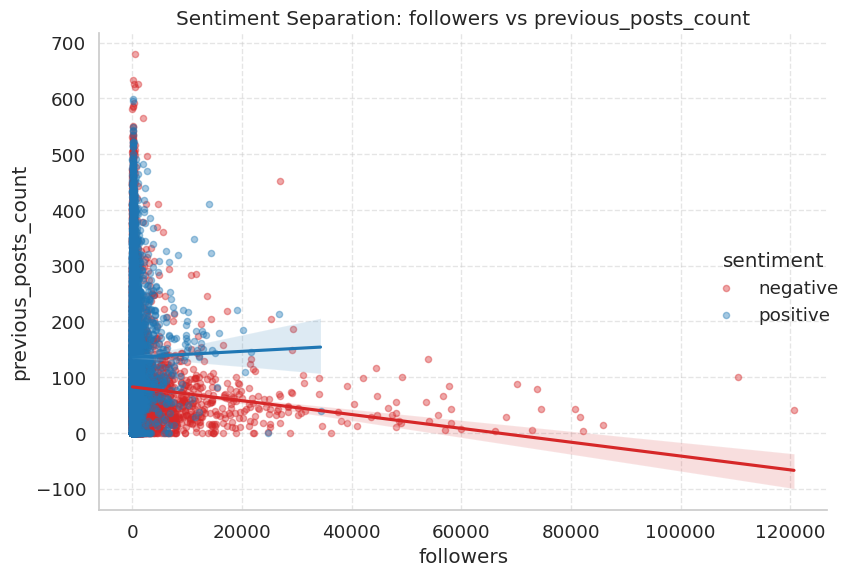

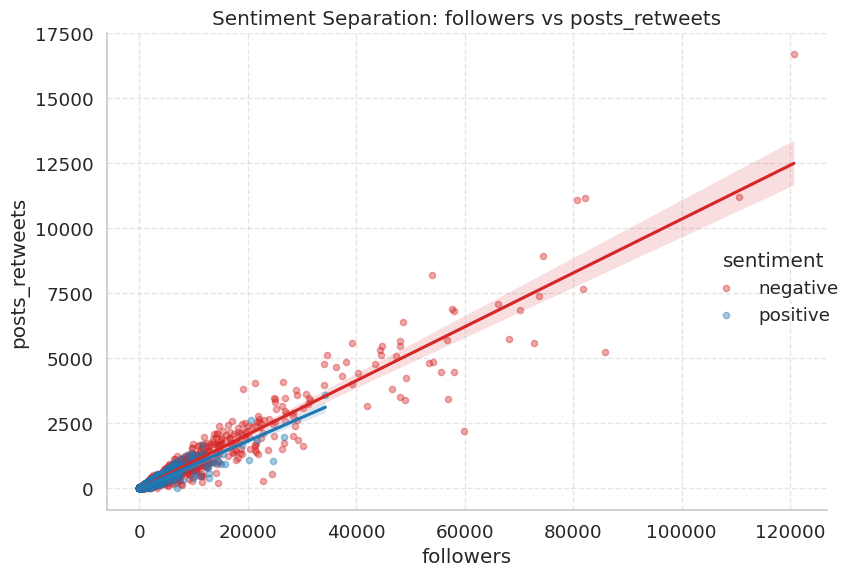

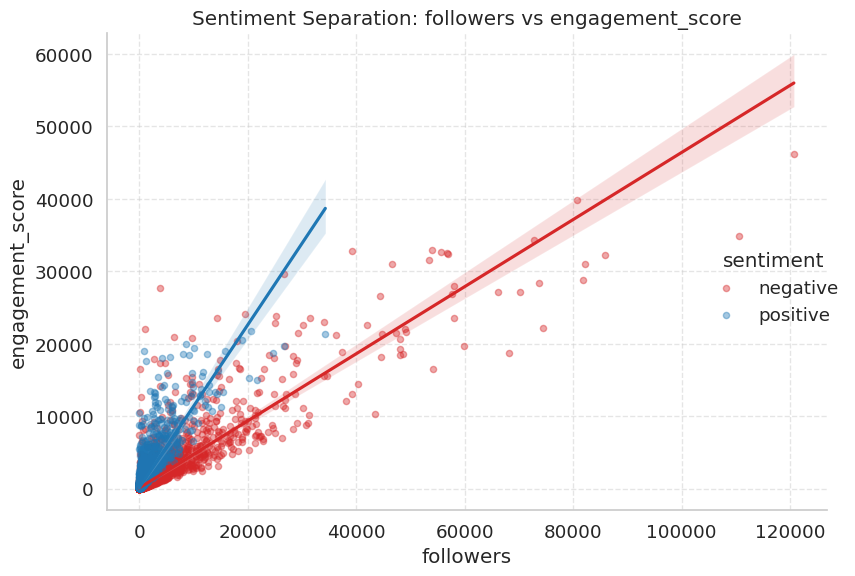

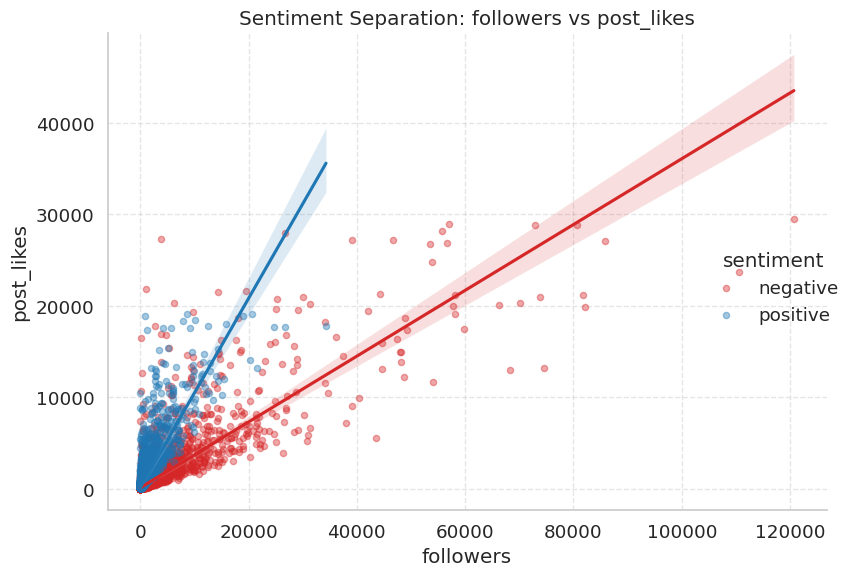

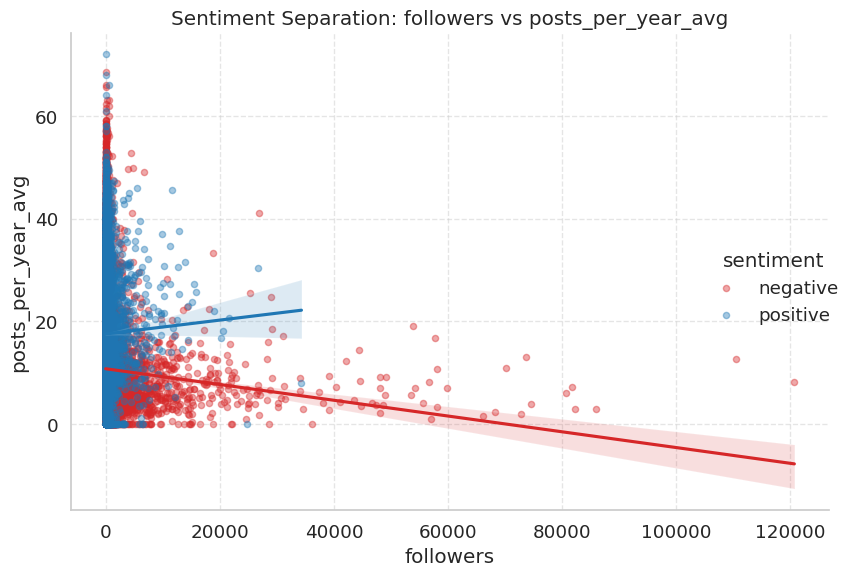

In [85]:
feature_pairs = [
    ('followers', 'previous_posts_count'),
    ('followers', 'posts_retweets'),
    ('followers', 'engagement_score'),
    ('followers', 'post_likes'),
    ('followers', 'posts_per_year_avg')
]

def plot_scatter_with_regression(df, x, y):
    subset = df[[x, y, 'sentiment']].dropna()


    sns.lmplot(data=subset, x=x, y=y, hue='sentiment',
               palette={'positive': '#1f77b4', 'negative': '#d62728'},
               scatter_kws={'alpha': 0.4, 's': 20},
               height=6, aspect=1.2)
    plt.title(f'Sentiment Separation: {x} vs {y}')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


for x, y in feature_pairs:
    plot_scatter_with_regression(df_clean, x, y)

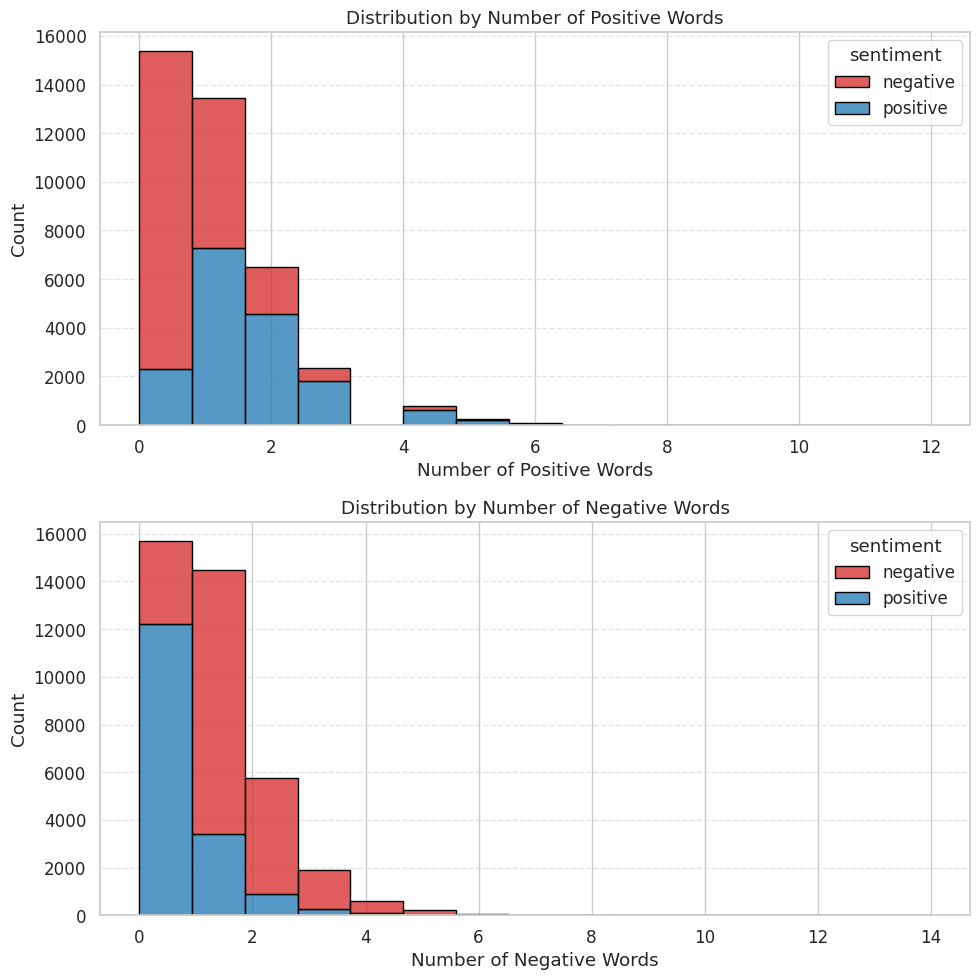

In [86]:


with open('positive-words.txt', 'r', encoding='ISO-8859-1') as f:
    positive_words = set([line.strip() for line in f if line.strip() and not line.startswith(';')])

with open('negative-words.txt', 'r', encoding='ISO-8859-1') as f:
    negative_words = set([line.strip() for line in f if line.strip() and not line.startswith(';')])


def count_sentiment_words(text, word_set):
    words = str(text).lower().split()
    return sum(word in word_set for word in words)

df_clean['positive_word_count'] = df_clean['text'].apply(lambda x: count_sentiment_words(x, positive_words))
df_clean['negative_word_count'] = df_clean['text'].apply(lambda x: count_sentiment_words(x, negative_words))

sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10, 10))


plt.subplot(2, 1, 1)
sns.histplot(
    data=df_clean,
    x='positive_word_count',
    hue='sentiment',
    bins=15,
    multiple='stack',
    palette={'positive': '#1f77b4', 'negative': '#d62728'},
    edgecolor='black'
)
plt.title('Distribution by Number of Positive Words')
plt.xlabel('Number of Positive Words')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.subplot(2, 1, 2)
sns.histplot(
    data=df_clean,
    x='negative_word_count',
    hue='sentiment',
    bins=15,
    multiple='stack',
    palette={'positive': '#1f77b4', 'negative': '#d62728'},
    edgecolor='black'
)
plt.title('Distribution by Number of Negative Words')
plt.xlabel('Number of Negative Words')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [87]:
# is_daytime_post: 1 if post published between 5:00 and 17:00
df_clean['is_daytime_post'] = df_clean['post_hour'].apply(lambda x: 1 if 5 <= x < 17 else 0)

# is_post_in_positive_season: 1 if month is Feb–Oct, else 0
df_clean['is_post_in_positive_season'] = df_clean['post_month'].apply(lambda x: 1 if 2 <= x <= 10 else 0)

# is_short_post: 1 if word_count < 20
df_clean['is_short_post'] = df_clean['word_count'].apply(lambda x: 1 if x < 20 else 0)

# is_high_post_frequency: 1 if posts_per_year_avg > 10
df_clean['is_high_post_frequency'] = df_clean['posts_per_year_avg'].apply(lambda x: 1 if x > 10 else 0)

# has_multiple_hashtags: 1 if num_hashtags >= 3
df_clean['has_multiple_hashtags'] = df_clean['num_hashtags'].apply(lambda x: 1 if x >= 3 else 0)

# is_younger_user: 1 if age < 30
df_clean['is_younger_user'] = df_clean['age'].apply(lambda x: 1 if x < 30 else 0)


In [88]:
df_selected = df_clean.copy()

cols_to_drop = [
    'id', 'text', 'post_datetime', 'embedded_content_url', 'username',
    'account_creation_date', 'email', 'birthday', 'profile_picture',
    'birthday_year', 'account_creation_date_year'
]
df_selected = df_selected.drop(columns=cols_to_drop)


from sklearn.preprocessing import MinMaxScaler

numeric_features = [
    'post_likes', 'posts_retweets', 'followers', 'previous_posts_count',
     'age', 'word_count',
    'engagement_score', 'posts_per_year_avg',
    'positive_word_count', 'negative_word_count'
]


existing_numeric = [col for col in numeric_features if col in df_selected.columns]


scaler = MinMaxScaler()
df_selected[existing_numeric] = scaler.fit_transform(df_selected[existing_numeric])



In [89]:
likes_bins = [0, 10, 100, 500, 1000, np.inf]
likes_labels = ['likes_0_10', 'likes_11_100', 'likes_101_500', 'likes_501_1000', 'likes_1000_plus']
likes_dummies = pd.get_dummies(pd.cut(df_selected['post_likes'], bins=likes_bins, labels=likes_labels)).astype(int)

follower_bins = [0, 100, 500, 1000, 5000, np.inf]
follower_labels = ['f_0_100', 'f_101_500', 'f_501_1k', 'f_1k_5k', 'f_5k_plus']
follower_dummies = pd.get_dummies(pd.cut(df_selected['followers'], bins=follower_bins, labels=follower_labels)).astype(int)

word_bins = [0, 10, 20, 40, np.inf]
word_labels = ['words_0_10', 'words_11_20', 'words_21_40', 'words_41_plus']
word_dummies = pd.get_dummies(pd.cut(df_selected['word_count'], bins=word_bins, labels=word_labels)).astype(int)

hashtag_bins = [0, 1, 2, 3, np.inf]
hashtag_labels = ['hashtags_0', 'hashtags_1', 'hashtags_2', 'hashtags_3_plus']
hashtag_dummies = pd.get_dummies(pd.cut(df_selected['num_hashtags'], bins=hashtag_bins, labels=hashtag_labels)).astype(int)

age_bins = [0, 20, 30, 40, 50, 60, np.inf]
age_labels = ['age_<20', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60+']
age_dummies = pd.get_dummies(pd.cut(df_selected['age'], bins=age_bins, labels=age_labels)).astype(int)


acc_bins = [0, 1, 3, 5, 10, np.inf]
acc_labels = ['acc_<1y', 'acc_1-3y', 'acc_3-5y', 'acc_5-10y', 'acc_10y+']
account_dummies = pd.get_dummies(pd.cut(df_selected['account_age'], bins=acc_bins, labels=acc_labels)).astype(int)

time_bucket_dummies = pd.get_dummies(df_selected['post_time_bucket'], prefix='time_bucket').astype(int)
weekend_dummies = pd.get_dummies(df_selected['is_weekend'], prefix='weekend').astype(int)

type_dummies = pd.get_dummies(df_selected['type'], prefix='type').astype(int)
checkmark_dummies = pd.get_dummies(df_selected['checkmark'], prefix='checkmark').astype(int)
content_type_dummies = pd.get_dummies(df_selected['content_type'], prefix='content').astype(int)


def month_to_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'fall'
    else:
        return 'unknown'

df_selected['season'] = df_selected['post_month'].apply(month_to_season)
season_dummies = pd.get_dummies(df_selected['season'], prefix='season').astype(int)


df_selected = pd.concat([
    df_selected,
    likes_dummies,
    follower_dummies,
    word_dummies,
    hashtag_dummies,
    age_dummies,
    account_dummies,
    time_bucket_dummies,
    weekend_dummies,
    type_dummies,
    checkmark_dummies,
    content_type_dummies,
    season_dummies

], axis=1)

bool_cols = df_selected.select_dtypes(include='bool').columns
df_selected[bool_cols] = df_selected[bool_cols].astype(int)



In [90]:
non_numeric_cols = df_selected.select_dtypes(exclude=['number']).columns
cols_to_drop = [col for col in non_numeric_cols if col != 'sentiment']

df_selected = df_selected.drop(columns=cols_to_drop)

# Fisher Score calculation
def fisher_score(df, feature_col, label_col='sentiment'):
    pos_vals = df.loc[df[label_col] == 'positive', feature_col].dropna()
    neg_vals = df.loc[df[label_col] == 'negative', feature_col].dropna()
    if pos_vals.empty or neg_vals.empty:
        return 0
    mean_pos, mean_neg = pos_vals.mean(), neg_vals.mean()
    std_pos, std_neg = pos_vals.std(ddof=1), neg_vals.std(ddof=1)
    return abs(mean_pos - mean_neg) / (std_pos + std_neg) if (std_pos + std_neg) else 0

# Calculate and print scores
numeric_features = df_selected.select_dtypes(include='number').columns
fisher_scores = {col: fisher_score(df_selected, col) for col in numeric_features}
fisher_scores_sorted = dict(sorted(fisher_scores.items(), key=lambda x: x[1], reverse=True))

for feature, score in fisher_scores_sorted.items():
    print(f"{feature}: {score:.4f}")

num_hashtags: 0.5523
negative_word_count: 0.5433
season_winter: 0.5261
is_post_in_positive_season: 0.5207
positive_word_count: 0.4978
has_multiple_hashtags: 0.4966
hashtags_3_plus: 0.4852
is_high_post_frequency: 0.4587
posts_per_year_avg: 0.3724
previous_posts_count: 0.3241
season_summer: 0.2953
season_spring: 0.2755
hashtags_2: 0.2379
checkmark_gold: 0.2295
checkmark_grey: 0.2295
checkmark_none: 0.1977
has_profile_picture: 0.1533
time_bucket_Night: 0.1527
likes_per_follower: 0.1394
is_daytime_post: 0.1379
time_bucket_Morning: 0.1267
is_younger_user: 0.1253
word_count: 0.1134
followers: 0.1081
posts_retweets: 0.1051
is_short_post: 0.0953
age: 0.0760
checkmark_blue: 0.0614
post_hour: 0.0609
age_<20: 0.0519
f_0_100: 0.0345
likes_0_10: 0.0275
time_bucket_Afternoon: 0.0251
engagement_score: 0.0117
acc_<1y: 0.0115
type_post: 0.0112
type_retweet: 0.0105
words_0_10: 0.0096
hashtags_1: 0.0093
post_datetime_year: 0.0071
time_bucket_Evening: 0.0066
content_image: 0.0065
account_age: 0.0064
post_

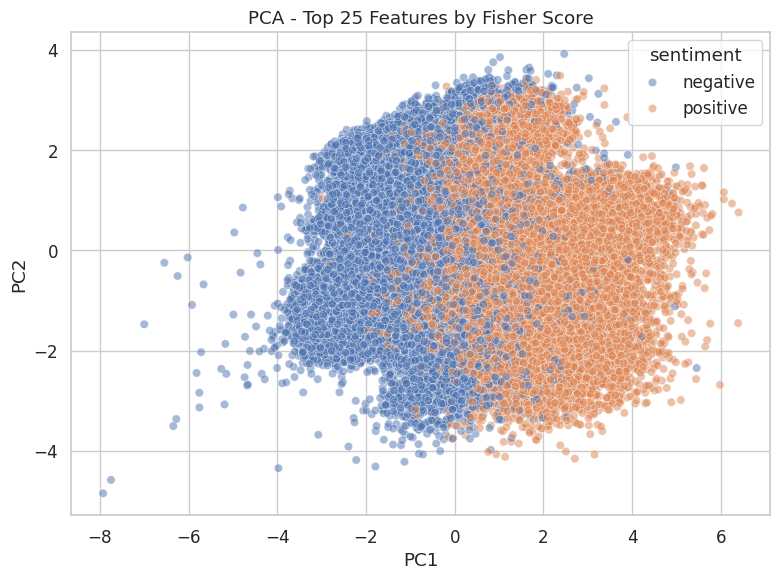

In [91]:

# Select top 30 features
top_30_features = list(fisher_scores_sorted.keys())[:30]

# Prepare data
df_top30 = df_selected[top_30_features + ['sentiment']].dropna()
X = df_top30.drop(columns=['sentiment'])
y = df_top30['sentiment']

# Standardize and PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['sentiment'] = y.values

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='sentiment', alpha=0.5)
plt.title('PCA - Top 25 Features by Fisher Score')
plt.grid(True)
plt.tight_layout()
plt.show()

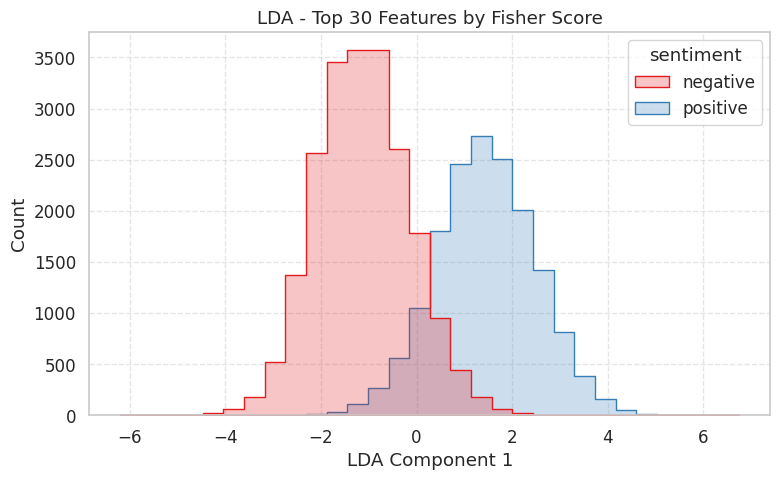

In [92]:
# LDA projection using top 30 features selected by Fisher Score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

y_encoded = y.map({'negative': 0, 'positive': 1})
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_scaled, y_encoded)

lda_df = pd.DataFrame({'LDA1': X_lda.flatten(), 'sentiment': y.values})

plt.figure(figsize=(8, 5))
sns.histplot(data=lda_df, x='LDA1', hue='sentiment', element='step', common_norm=False, bins=30, palette='Set1')
plt.title('LDA - Top 30 Features by Fisher Score')
plt.xlabel('LDA Component 1')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
